Installation - if you're not using Colab, you will need to install `tensorflow` and `tensorflow-datasets` as well

In [ ]:
!pip install git+https://github.com/am1tyadav/teal pydub -q

Restart kernel after installing packages

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

Import TensorFlow, TFDS and Teal

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from IPython.display import Audio
import tensorflow_datasets as tfds
import teal
import matplotlib.pyplot as plt

2022-02-07 16:06:46.878525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-07 16:06:46.878542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Download the Spoken Digit dataset

In [2]:
dataset = tfds.load("spoken_digit", data_dir="./tmp")

2022-02-07 16:06:48.688724: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-07 16:06:48.688746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amit-hp): /proc/driver/nvidia/version does not exist
2022-02-07 16:06:48.689406: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
SAMPLE_RATE = 8000
DURATION = 1
SAMPLE_LEN = DURATION * SAMPLE_RATE
N_FFT = 1024
HOP_LEN = 256
N_MELS = 28


def get_feature(_input, expand=True):
    if expand:
        _in = tf.expand_dims(_input, axis=0)
    else:
        _in = _input
    _audio = teal.NormalizeAudio()(_in)
    _stft = teal.AudioToSTFT(n_fft=N_FFT, hop_length=HOP_LEN)(_audio)
    _spec, _phase = teal.STFTToSpecAndPhase()(_stft)
    _mel_spec = teal.SpectrogramToMelSpec(sample_rate=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)(_spec)
    _log_mel_spec = teal.PowerToDb()(_mel_spec)
    return tf.squeeze(teal.NormalizeSpectrum()(_log_mel_spec), axis=0)

    
def generate_sin():
    f = np.random.randint(100, 800)
    x = np.arange(SAMPLE_LEN)
    return np.random.uniform(0.01, 0.1, size=(1, )) * np.sin(2 * np.pi * f * x / SAMPLE_RATE)


def process_example_audio(example):
    audio = example["audio"]
    audio = tf.cast(audio, dtype=tf.float32) / 32768.

    num_samples = tf.shape(audio)[0]
    
    if num_samples > SAMPLE_LEN:
        output = audio[:SAMPLE_LEN]
    else:
        # Otherwise pad audio 
        padding = SAMPLE_LEN - num_samples

        if padding == 0:
            output = audio
        else:
            output = tf.pad(audio, [[0, padding]])

    noisy = output + generate_sin()
    return noisy, output


def process_example(example):
    noisy, output = process_example_audio(example)
    example_log_mel = get_feature(output)
    noisy_log_mel = get_feature(noisy)
    return noisy_log_mel, example_log_mel

In [4]:
BATCH_SIZE = 5
TOTAL_EXAMPLES = len(dataset["train"])
NUM_TRAIN = int(0.7 * TOTAL_EXAMPLES)
NUM_VALID = TOTAL_EXAMPLES - NUM_TRAIN


dataset = dataset["train"]
dataset = dataset.map(process_example)

print(f"Splitting dataset into {NUM_TRAIN} training examples and {NUM_VALID} validation examples")

train_ds = dataset.take(NUM_TRAIN).batch(BATCH_SIZE)
valid_ds = dataset.skip(NUM_TRAIN).batch(BATCH_SIZE)

Splitting dataset into 1750 training examples and 750 validation examples


In [5]:
train_ds = train_ds.cache()
valid_ds = valid_ds.cache()

In [6]:
examples, labels = next(iter(train_ds.take(1)))

2022-02-07 16:06:53.612468: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-02-07 16:06:53.616932: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


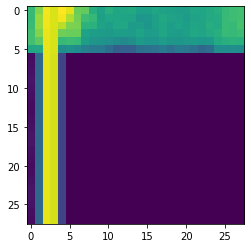

In [7]:
plt.imshow(examples[0]);

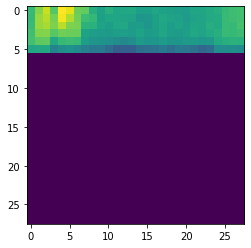

In [8]:
plt.imshow(labels[0]);

We will create a model using `tf.keras` Functional API

In [11]:
def encode(_input):
    _x = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(_input)

    for i in range(0, 2):
        _x = layers.Conv2D(32, 3, strides=2, padding="same", activation="tanh")(_x)
        _x = layers.BatchNormalization()(_x)

    _x = layers.Flatten()(_x)
    _latent = layers.Dense(32, activation="tanh")(_x)
    
    return _latent


def decode(_input):
    _x = layers.Dense(7 * 7 * 32, activation="tanh")(_input)
    _x = layers.Reshape((7, 7, 32))(_x)

    for i in range(0, 2):
        _x = layers.UpSampling2D(2)(_x)
        _x = layers.Conv2D(32, 3, padding="same", activation="tanh")(_x)
        _x = layers.BatchNormalization()(_x)

    _x = layers.Conv2D(1, 1, padding="same", activation="tanh")(_x)

    _pred_log_mel_spec = layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(_x)
    _pred_norm_log_mel = teal.NormalizeSpectrum()(_pred_log_mel_spec)
    
    return _pred_norm_log_mel


def create_model():
    _input = layers.Input(shape=(28, 28))
    _latent = encode(_input)
    _pred_norm_log_mel = decode(_latent)

    _model = models.Model(
        _input, _pred_norm_log_mel
    )
    return _model

_model = create_model()
_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 lambda_4 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                           

In [12]:
_model.compile(
    loss=tf.keras.losses.CosineSimilarity(),
    optimizer="adam"
)

In [13]:
_ = _model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.8),
    ]
)

Epoch 1/20
350/350 [==============================] - 6s 15ms/step - loss: -0.8552 - val_loss: -0.8841 - lr: 0.0010
Epoch 2/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9110 - val_loss: -0.9240 - lr: 0.0010
Epoch 3/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9288 - val_loss: -0.9245 - lr: 0.0010
Epoch 4/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9371 - val_loss: -0.9403 - lr: 0.0010
Epoch 5/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9443 - val_loss: -0.9450 - lr: 0.0010
Epoch 6/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9494 - val_loss: -0.9484 - lr: 0.0010
Epoch 7/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9522 - val_loss: -0.9506 - lr: 0.0010
Epoch 8/20
350/350 [==============================] - 2s 7ms/step - loss: -0.9540 - val_loss: -0.9541 - lr: 0.0010
Epoch 9/20
350/350 [==============================] - 2s 7ms/step - loss: -0.95

In [20]:
# Lets load the dataset again but just audio

dataset = tfds.load("spoken_digit", data_dir="./tmp")
dataset = dataset["train"]
dataset = dataset.map(process_example_audio)
dataset = dataset.batch(1)

In [64]:
i = iter(dataset)

2022-02-07 16:24:13.407318: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [98]:
noisy, label = next(i)

In [108]:
Audio(noisy[0], rate=SAMPLE_RATE)

In [109]:
Audio(label[0], rate=SAMPLE_RATE)

In [110]:
_audio = teal.NormalizeAudio()(noisy)

In [111]:
_stft = teal.AudioToSTFT(n_fft=N_FFT, hop_length=HOP_LEN)(_audio)
_spec, _phase = teal.STFTToSpecAndPhase()(_stft)
_mel_spec = teal.SpectrogramToMelSpec(sample_rate=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)(_spec)
_log_mel_spec = teal.PowerToDb()(_mel_spec)
_norm_spec = teal.NormalizeSpectrum()(_log_mel_spec)

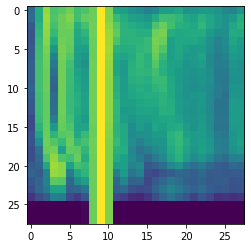

In [112]:
plt.imshow(_norm_spec[0]);

In [113]:
preds = _model.predict(_norm_spec)

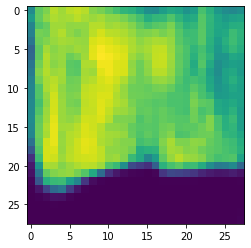

In [114]:
plt.imshow(preds[0]);

In [115]:
x = teal.DbToPower()(preds)
x = teal.MelSpecToSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)(x)
x = teal.SpecAndPhaseToSTFT()([x, _phase])
x = teal.STFTToAudio(n_fft=N_FFT, hop_length=HOP_LEN)(x)
_pred_audio_norm = teal.NormalizeAudio()(x)

In [116]:
Audio(_pred_audio_norm[0], rate=SAMPLE_RATE)